In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

scipy solve_ivp - does integration, can eliminate the stepwise 1st order, handles equation for me

In [2]:
start_time = time.time()

In [60]:
r_min, r_max = (.8, 1.2)
seeds = [.3, 1, 2]
n_cells = int(1e7)
matrix_bins = 75
passages = 5
k = 6.5
adj_k = False

max_r_depres, min_r_depres = (.5, .8)

In [4]:
def r0_mc(x):
    if 0.8 <= x <= 1.2:
        return -10 * (x - 0.7) * (x - 1.3)
    else:
        return 0

def tfxn_mc(x):
    x0, x1, x2, x3, x4 = (0, 7.37871, -17.2468, 13.5574, -3.38936)
    return x0 + x1*x +x2*x**2 + x3*x**3 + x4*x**4
    
    
def r_mult_mc(x, cutoff = .3, max_r_depres = max_r_depres, min_r_depres = min_r_depres):
    
    if x < cutoff:
        return 0
    else:
        m = (max_r_depres - min_r_depres) / (1 - cutoff)
        b = max_r_depres - m


        return m * x + b

In [5]:
def generate_samples(pdf, n_cells, d_min = r_min, d_max = r_max):
    output = []
    
    # Define the range for generating samples
    x_range = np.linspace(d_min, d_max, n_cells)
    
    # Create a normalized r0_mc within the specified range
    normalized_pdf = np.array([pdf(x) for x in x_range])
    normalized_pdf /= np.sum(normalized_pdf)
    
    # Generate samples
    output = np.random.choice(x_range, size=n_cells, p=normalized_pdf)
    
    return output

In [6]:
cell_r0 = generate_samples(r0_mc, n_cells, d_min = r_min, d_max = r_max)

In [7]:
t_min, t_max = (0,1)
cell_tfxn_0 = generate_samples(tfxn_mc, n_cells, t_min, t_max)

In [8]:
r_mult = []
for i in cell_tfxn_0:
    r_mult.append(r_mult_mc(i))

In [9]:
r_adj_0 = cell_r0 * r_mult

In [10]:
def colorplot(matrix, title = ''):
    plt.imshow(matrix, cmap='viridis', origin='lower', extent=[t_spread.min(), t_spread.max(), r_spread.min(), r_spread.max()])
    plt.colorbar(label='Count')  # Add a colorbar for reference
    plt.xlabel('Cell_tfxn')
    plt.ylabel('R_adj')
    plt.title(title)
    plt.show()

In [11]:
r_adj = []
cell_tfxn = []
for i, r, t in zip(range(len(r_adj_0)), r_adj_0, cell_tfxn_0):
    if r != 0:
        r_adj.append(r)
        cell_tfxn.append(t)   

10%
20%
30%
40%
50%
60%
70%
80%
90%


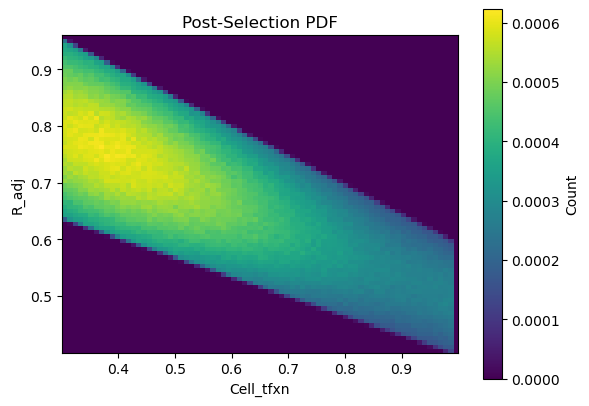

In [12]:
percent = 0

bins = matrix_bins
n_mtx = np.zeros((bins, bins))
r_spread = np.linspace(np.min(r_adj), np.max(r_adj), bins)
t_spread = np.linspace(np.min(cell_tfxn), np.max(cell_tfxn), bins)


# Iterate through the paired data
for i in range(len(r_adj)):
    r_bin = np.digitize(r_adj[i], r_spread) - 1  # Find the bin for r_adj[i]
    t_bin = np.digitize(cell_tfxn[i], t_spread) - 1  # Find the bin for cell_tfxn[i]
    
    # Check if the indices are within bounds
    if 0 <= r_bin < bins and 0 <= t_bin < bins:
        n_mtx[r_bin][t_bin] += 1  # Increment the count in the corresponding bin

    if np.floor(i / len(r_adj) * 100) > percent + 10:
        percent += 10
        print('{}%'.format(percent))
n_mtx_0 = n_mtx.copy()
colorplot(n_mtx_0/ np.sum(n_mtx_0), title = 'Post-Selection PDF')

In [63]:
def growth_eq(matrix, t_max = 3, dt = .01, seed = 0.3, passages = 1, k = k, r_spread = r_spread, plot = True, adj_k = adj_k):
    
    if adj_k:
        k = k+seed
    outputs = [matrix]
    p = 0
    
    while p < passages:
        nt = np.sum(matrix)
        doubles = np.log2(nt / seed)
        matrix = seed * matrix / np.sum(matrix)    
        t = 0
        
        
        if plot == True:
            if p == 0:
                doubles = float(0)
            colorplot(matrix, title = 'P = {}, Seed = {}, Nf = {:.2}, D = {:.2}'.format(p, seed, nt, doubles))
            
        
        
        while t < t_max:
            nt = np.sum(matrix)
            
            for i, row in enumerate(matrix):
                for j, pdf in enumerate(row):
                    
                    if pdf == 0:
                        dn = 0
                        
                    else:
                        rate = r_spread[i]
                        dn = rate * pdf * (k - nt) / k * dt
                    
                    matrix[i][j] += dn
            t += dt
            nt = np.sum(matrix)
        p += 1
        nt = np.sum(matrix)
        
        outputs.append(matrix)
    return outputs

In [52]:
def plots_over_time(mtxs,seed, t_spread = t_spread, r_spread = r_spread):
     
    for i, mtx in enumerate(mtxs):
        y = np.sum(mtx, axis = 0)
        y = y / np.sum(mtx)
        plt.plot(t_spread, y, label = 'Passage {}'.format(i))
    
    plt.title('Tfxn by passage, Seed = {}'.format(seed))
    plt.xlabel('Tfxn')
    plt.ylabel('PDF')
    plt.legend()
    plt.show()

    for i, mtx in enumerate(mtxs):
        y = np.sum(mtx, axis = 1)
        y = y / np.sum(mtx)
        plt.plot(r_spread, y, label = 'Passage {}'.format(i))
    plt.title('Rate by passage, Seed = {}'.format(seed))
    plt.xlabel('Rate')
    plt.ylabel('PDF')
    plt.legend()
    plt.show()


In [53]:
def find_percentiles(mtxs_list, seeds, threshold = .025):
    for seed, mtx_list in zip(seeds, mtxs_list):
        print()
        print('Seed = {}e6, {:.2f} percentile'.format(seed,(1-threshold)*100))
        for i, mtx in enumerate(mtx_list):
            y = np.sum(mtx, axis = 0)
            y = y / np.sum(mtx)

            n = 0
            total = 0
            while total < threshold:
                n -= 1
                total += y[n]


            print('{:.1f}% Transfection, Passage = {}'.format(
                t_spread[n]*100, i))


6.5


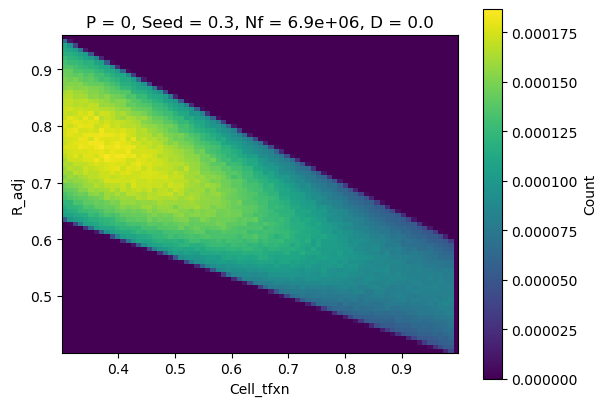

6.5


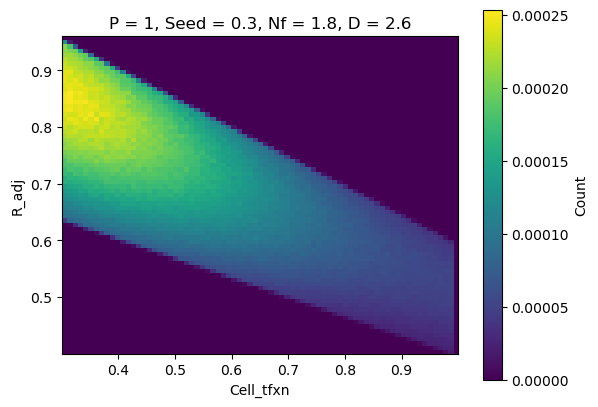

6.5


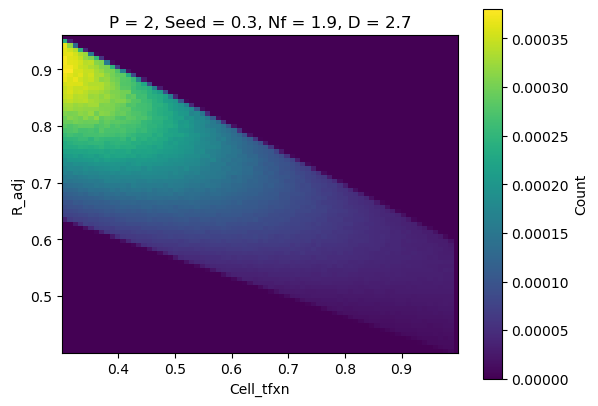

6.5


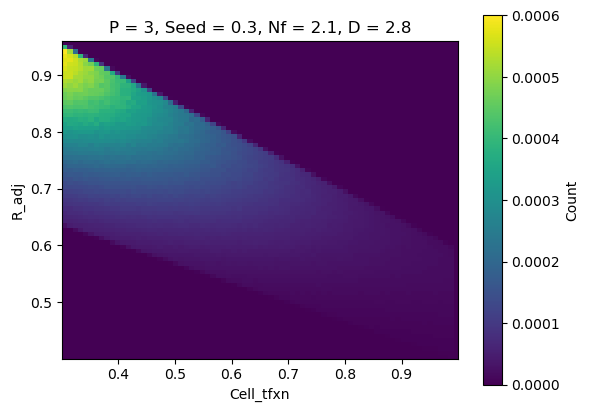

6.5


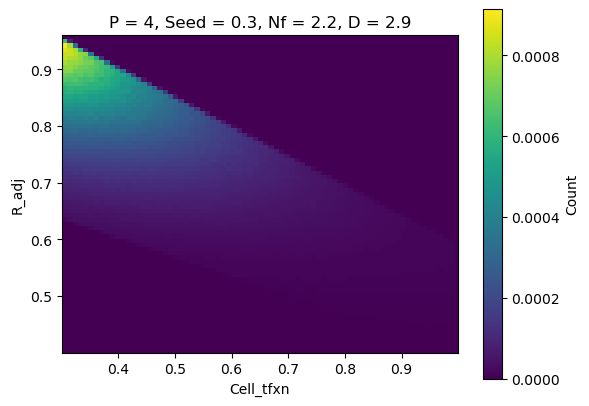

6.5
6.5


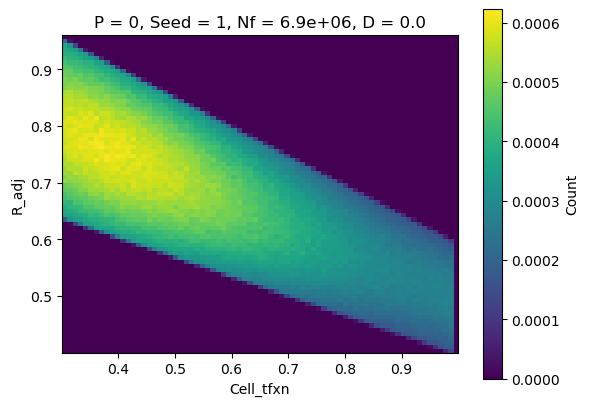

6.5


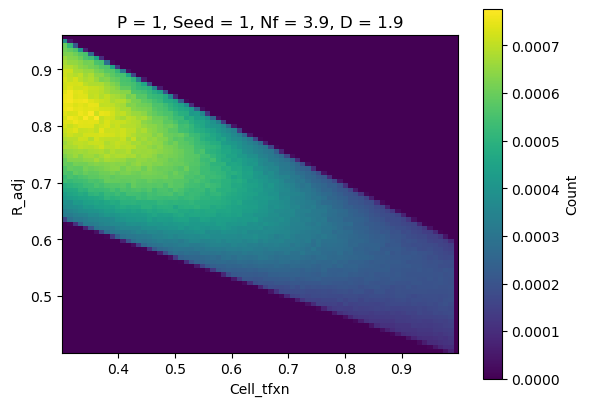

6.5


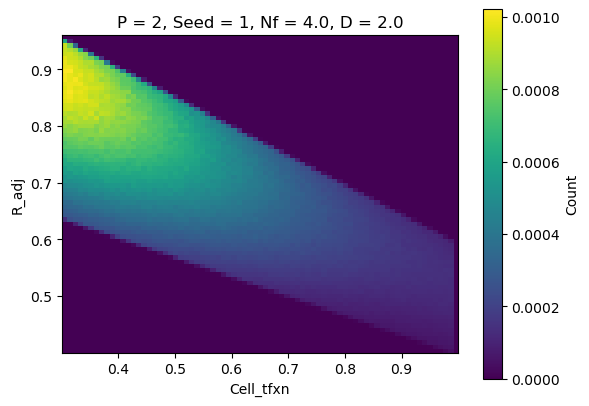

6.5


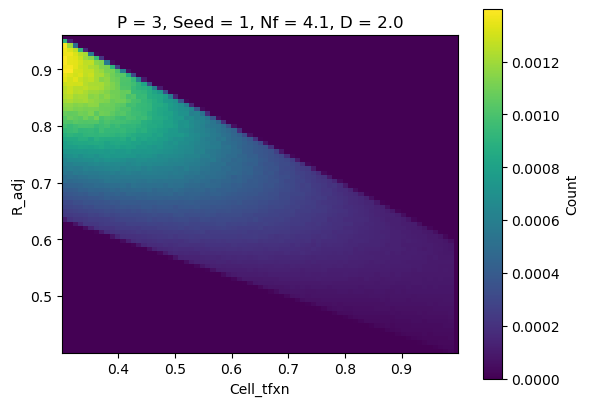

6.5


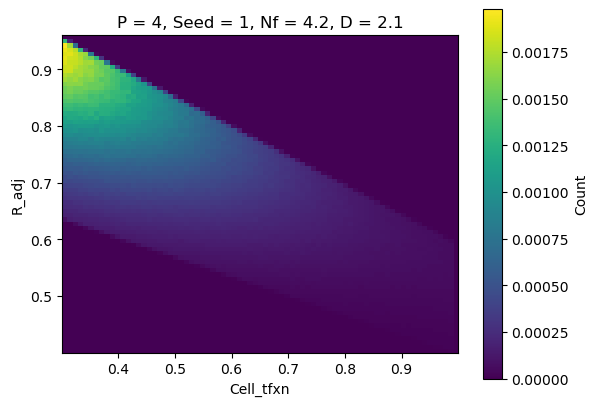

6.5
6.5


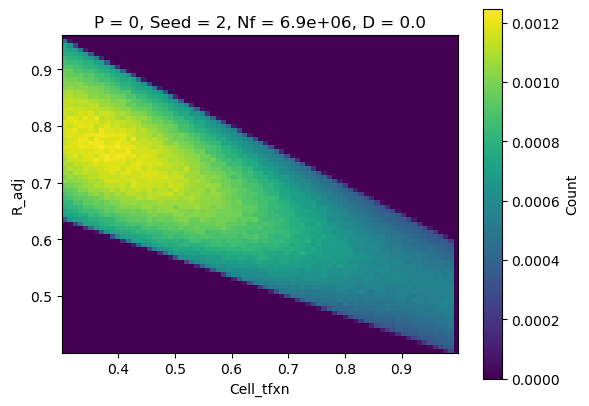

6.5


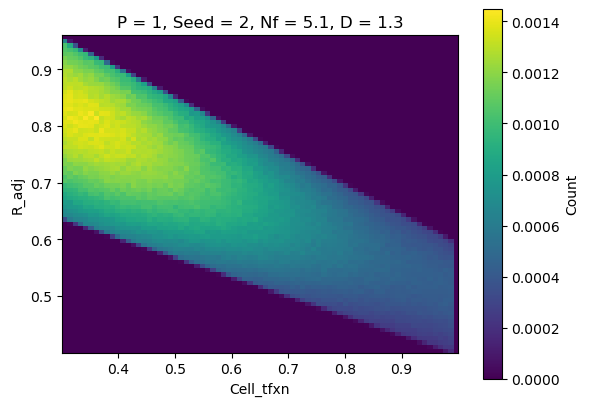

6.5


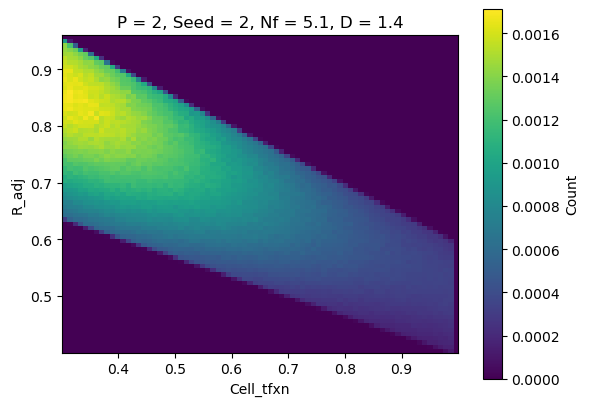

6.5


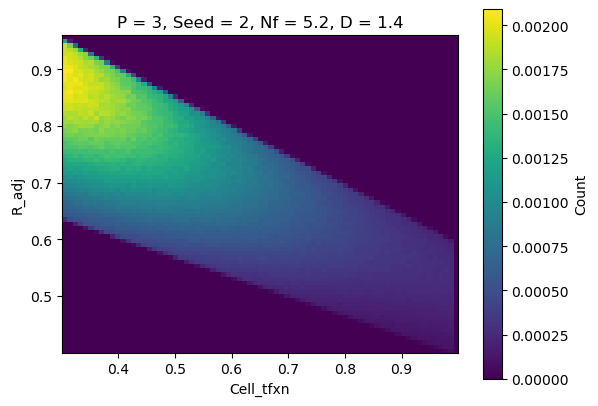

6.5


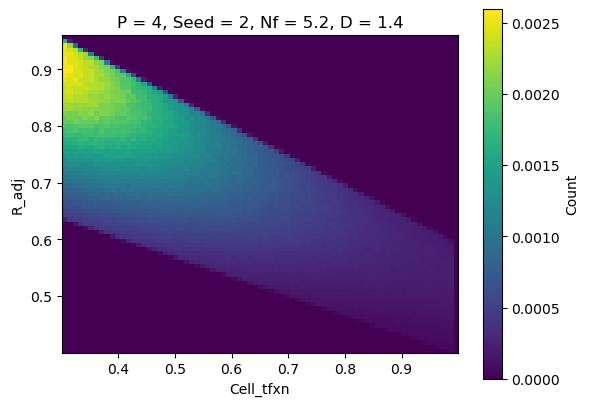

6.5


In [62]:
matricies_list = []
for seed in seeds:
    mtx = growth_eq(n_mtx_0, passages = passages, plot = True, seed = seed)
    matricies_list.append(mtx)

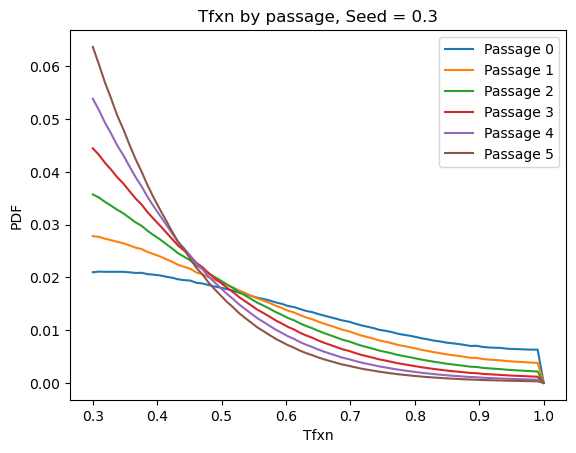

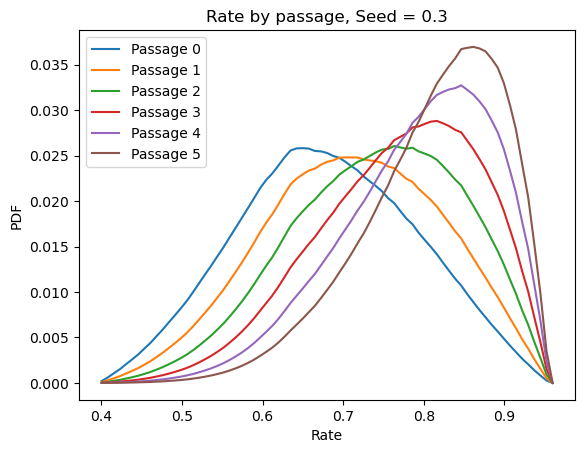

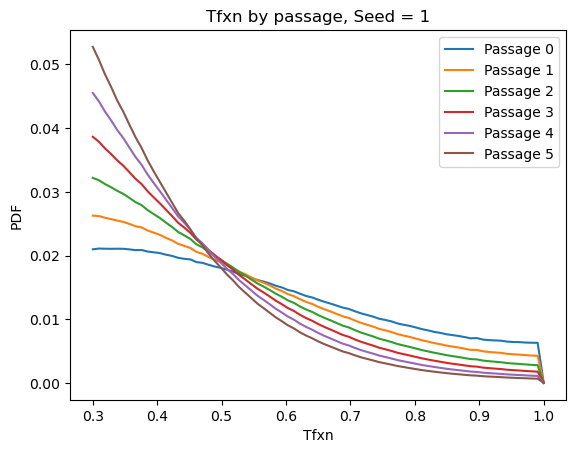

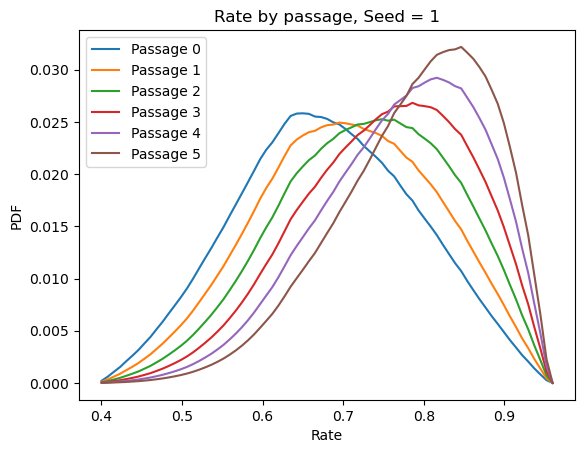

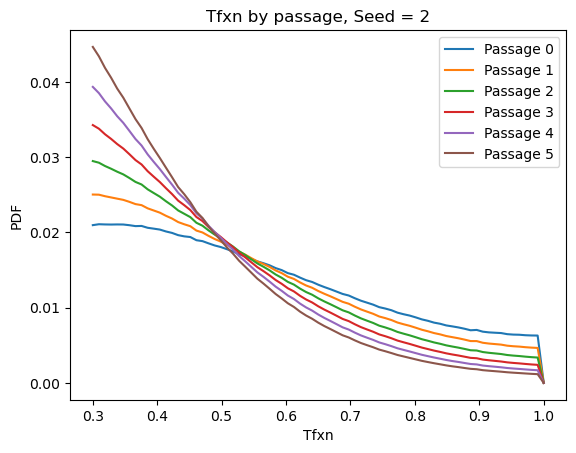

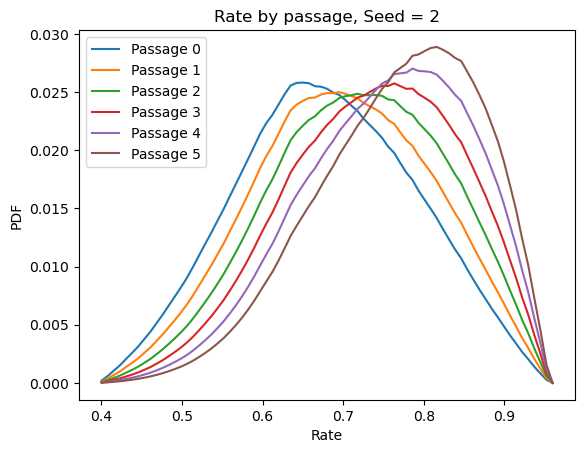

In [59]:
for mtx, seed in zip(matricies_list, seeds):
    plots_over_time(mtx, seed)

In [64]:
find_percentiles(matricies_list, seeds)


Seed = 0.3e6, 97.50 percentile
96.2% Transfection, Passage = 0
93.4% Transfection, Passage = 1
90.5% Transfection, Passage = 2
84.9% Transfection, Passage = 3
79.2% Transfection, Passage = 4
74.5% Transfection, Passage = 5

Seed = 1e6, 97.50 percentile
96.2% Transfection, Passage = 0
94.3% Transfection, Passage = 1
92.4% Transfection, Passage = 2
88.6% Transfection, Passage = 3
84.9% Transfection, Passage = 4
81.1% Transfection, Passage = 5

Seed = 2e6, 97.50 percentile
96.2% Transfection, Passage = 0
94.3% Transfection, Passage = 1
93.4% Transfection, Passage = 2
91.5% Transfection, Passage = 3
89.6% Transfection, Passage = 4
87.7% Transfection, Passage = 5


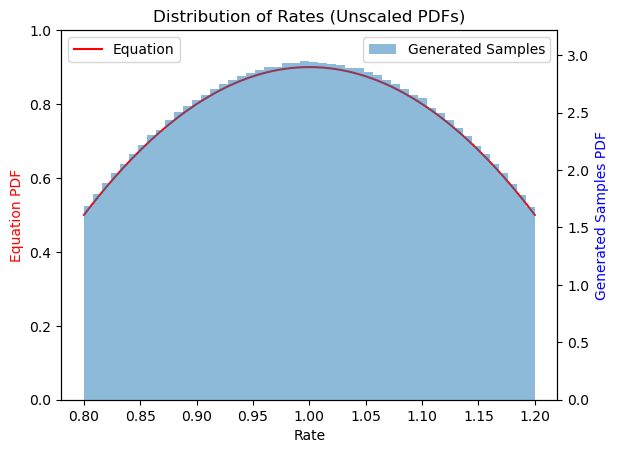

In [19]:


# Calculate the area under the r0_mc curve
x_values = np.linspace(0.8, 1.2, 1000)
y_values = np.array([r0_mc(x) for x in x_values])
pdf_area = np.trapz(y_values, x_values)

# Calculate the area under the r0_mc curve
x_values = np.linspace(0.8, 1.2, 1000)
y_values = np.array([r0_mc(x) for x in x_values])
pdf_area = np.trapz(y_values, x_values)

# Calculate the area under the unscaled histogram
hist, bins = np.histogram(cell_r0, bins=50, density=True)
hist_area = np.trapz(hist, bins[:-1])

# Calculate the scale factor between the integrals
scale_factor = pdf_area / hist_area

# Create the figure and the primary subplot
fig, ax1 = plt.subplots()

# Plot the r0_mc on the primary y-axis with y-limits 0 to 1
ax1.plot(x_values, y_values, 'r', label='Equation')
ax1.set_xlabel('Rate')
ax1.set_ylabel('Equation PDF', color='r')
ax1.set_ylim(0, 1)

# Create a secondary y-axis for the histogram
ax2 = ax1.twinx()

# Plot the unscaled histogram on the secondary y-axis with y-limits 0 to 1/scale_factor
ax2.hist(cell_r0, bins=50, alpha=0.5, label='Generated Samples', density=True)
ax2.set_ylabel('Generated Samples PDF', color='b')
ax2.set_ylim(0, 1 / scale_factor)

# Set labels and legends
ax1.legend(loc = 'upper left')
ax2.legend(loc='upper right')
plt.title('Distribution of Rates (Unscaled PDFs)')
plt.show()


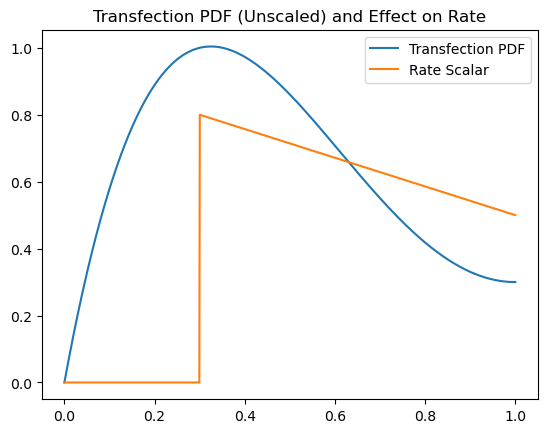

In [20]:
x = np.linspace(0,1,1000)
yt = tfxn_mc(x)
plt.plot(x,yt, label = 'Transfection PDF')


ys = []
for i in x:
    ys.append(r_mult_mc(i))
plt.plot(x,ys, label = 'Rate Scalar')
plt.legend()
plt.title('Transfection PDF (Unscaled) and Effect on Rate')
plt.show()

In [21]:
end_time = time.time()
duration = end_time - start_time

minutes = int(duration // 60)
seconds = int(duration % 60)

if len(str(seconds)) < 2:
    seconds = '0' + str(seconds)
    

print(f"Code execution took {minutes}:{seconds}")

Code execution took 2:32
